In [1]:
import fitz  # PyMuPDF for PDF extraction
import os
import pandas as pd

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    try:
        # Open the provided PDF file
        doc = fitz.open(pdf_path)
        
        text = ""
        # Loop through each page and extract text
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)  # Load each page
            text += page.get_text("text")  # Extract text from the page
        
        return text
    except Exception as e:
        print(f"Error processing {pdf_path}: {e}")
        return ""

# Function to extract text from PDFs in a folder (including subfolders)
def extract_text_from_folder(folder_path, label="unknown"):
    data = []
    # Use os.walk to go through all subfolders and files
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(".pdf"):  # Only process PDF files
                pdf_path = os.path.join(root, file_name)
                extracted_text = extract_text_from_pdf(pdf_path)
                # Get relative path of file (for better clarity)
                relative_path = os.path.relpath(pdf_path, folder_path)
                
                # Store file name, extracted text, and label (publishable/non-publishable)
                data.append({
                    "filename": relative_path, 
                    "extracted_text": extracted_text,
                    "label": label
                })
    
    return pd.DataFrame(data)

# Define the folder paths
reference_folder = "/Users/ranadipgope/Documents/kharagpur/reference"  # Root folder containing 'publishable' and 'non-publishable'

# Initialize DataFrames to store extracted text from both categories
publishable_folder = os.path.join(reference_folder, "publishable")
non_publishable_folder = os.path.join(reference_folder, "non-publishable")

# Extract text from the 'publishable' folder (and its subfolders)
publishable_df = extract_text_from_folder(publishable_folder, label="publishable")

# Extract text from the 'non-publishable' folder
non_publishable_df = extract_text_from_folder(non_publishable_folder, label="non-publishable")

# Combine both DataFrames into one
combined_df = pd.concat([publishable_df, non_publishable_df], ignore_index=True)

# Save the combined DataFrame to a CSV file
combined_df.to_csv("train.csv", index=False)

# Print the first few rows to verify the results
print(combined_df.head())


           filename                                     extracted_text  \
0  NeurIPS/R012.pdf  Safe Predictors for Input-Output Specification...   
1  NeurIPS/R013.pdf  Generalization in ReLU Networks via Restricted...   
2      KDD/R011.pdf  Addressing Popularity Bias with Popularity-Con...   
3      KDD/R010.pdf  Detecting Medication Usage in Parkinson’s Dise...   
4    EMNLP/R009.pdf  The Importance of Written Explanations in\nAgg...   

         label  
0  publishable  
1  publishable  
2  publishable  
3  publishable  
4  publishable  


In [2]:
import fitz  # PyMuPDF for PDF extraction
import os
import pandas as pd

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    try:
        # Open the provided PDF file
        doc = fitz.open(pdf_path)
        
        text = ""
        # Loop through each page and extract text
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)  # Load each page
            text += page.get_text("text")  # Extract text from the page
        
        return text
    except Exception as e:
        print(f"Error processing {pdf_path}: {e}")
        return ""

# Function to extract text from PDFs in a folder (including subfolders)
def extract_text_from_folder(folder_path):
    data = []
    # Use os.walk to go through all subfolders and files
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(".pdf"):  # Only process PDF files
                pdf_path = os.path.join(root, file_name)
                extracted_text = extract_text_from_pdf(pdf_path)
                # Get relative path of file (for better clarity)
                relative_path = os.path.relpath(pdf_path, folder_path)
                
                # Store file name, extracted text, and label
                data.append({
                    "filename": relative_path, 
                    "extracted_text": extracted_text
                })
    
    return pd.DataFrame(data)

# Define the folder path for papers
papers_folder = "/Users/ranadipgope/Documents/kharagpur/papers"  # Update with your path

# Extract text from the 'papers' folder (and its subfolders)
papers_df = extract_text_from_folder(papers_folder)

# Save the extracted text from papers to a CSV file
papers_df.to_csv("test.csv", index=False)

# Print the first few rows to verify the results
print(papers_df.head())


   filename                                     extracted_text
0  P005.pdf  Collaborative Clothing Segmentation and\nIdent...
1  P011.pdf  Controlling False Discovery Rates in Detecting...
2  P039.pdf  RAG Optimization via Galactic Kitten Dynamics ...
3  P038.pdf  Utilizing Graph Neural Networks to Analyze Esp...
4  P010.pdf  Enhanced Reinforcement Learning for Recommende...


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the train and test datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Preprocess the data
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = "".join([char if char.isalnum() or char.isspace() else " " for char in text])  # Remove special chars
    return text

train_df["extracted_text"] = train_df["extracted_text"].apply(preprocess_text)
test_df["extracted_text"] = test_df["extracted_text"].apply(preprocess_text)

# Encode labels for training data (0: Non-Publishable, 1: Publishable)
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])

# Tokenize and pad the text
tokenizer = Tokenizer(num_words=10000)  # Increased max words for richer vocabulary
tokenizer.fit_on_texts(train_df["extracted_text"])

X_train = tokenizer.texts_to_sequences(train_df["extracted_text"])
X_test = tokenizer.texts_to_sequences(test_df["extracted_text"])

max_seq_length = 700  # Increased max sequence length for longer context
X_train = pad_sequences(X_train, maxlen=max_seq_length, padding="post")
X_test = pad_sequences(X_test, maxlen=max_seq_length, padding="post")

y_train = train_df["label"].values

# Define the enhanced model
model = Sequential([
    Embedding(input_dim=10000, output_dim=256, input_length=max_seq_length),  # Increased embedding dimensions
    Bidirectional(LSTM(128, return_sequences=True)),  # First LSTM layer with 128 units
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=True)),  # Second LSTM layer with 128 units
    Dropout(0.4),
    Bidirectional(LSTM(64)),  # Final LSTM layer with 64 units
    Dropout(0.4),
    Dense(128, activation='relu'),  # Fully connected layer with 128 units
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Save the model
model.save("publishability_model_high_lstm.h5")

# Predict on the test data
predictions = model.predict(X_test)
test_df["prediction"] = (predictions > 0.5).astype(int)

# Decode predictions to labels
test_df["prediction_label"] = label_encoder.inverse_transform(test_df["prediction"])

# Save results
test_df.to_csv("test_with_predictions.csv", index=False)

# Print a sample of predictions
print(test_df.head())


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 0.6915 - val_accuracy: 0.0000e+00 - val_loss: 0.7088
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8333 - loss: 0.6742 - val_accuracy: 0.0000e+00 - val_loss: 0.7289
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8333 - loss: 0.6576 - val_accuracy: 0.0000e+00 - val_loss: 0.7647
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8333 - loss: 0.6255 - val_accuracy: 0.0000e+00 - val_loss: 0.8312
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8333 - loss: 0.5718 - val_accuracy: 0.0000e+00 - val_loss: 0.9678
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8333 - loss: 0.4984 - val_accuracy: 0.0000e+00 - val_loss: 1.2846
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8333 - loss: 0.3973 - val_accuracy: 0.0000e+00 - val_loss: 2.0025
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8333 - loss: 0.3749 - val_accuracy: 0.0000e+00 - val_loss: 2.

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step
   filename                                     extracted_text  prediction  \
0  P005.pdf  collaborative clothing segmentation and\nident...           1   
1  P011.pdf  controlling false discovery rates in detecting...           1   
2  P039.pdf  rag optimization via galactic kitten dynamics ...           1   
3  P038.pdf  utilizing graph neural networks to analyze esp...           1   
4  P010.pdf  enhanced reinforcement learning for recommende...           1   

  prediction_label  
0      publishable  
1      publishable  
2      publishable  
3      publishable  
4      publishable  


In [4]:
import pandas as pd

# Load the test_with_predictions.csv file
test_df = pd.read_csv("test_with_predictions.csv")

# Count the occurrences of 0 and 1 in the "prediction" column
prediction_counts = test_df["prediction"].value_counts()

# Print the counts
print("Count of predictions:")
print(f"0 (Non-Publishable): {prediction_counts.get(0, 0)}")
print(f"1 (Publishable): {prediction_counts.get(1, 0)}")


Count of predictions:
0 (Non-Publishable): 0
1 (Publishable): 135


In [5]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Load the test_with_predictions.csv file
test_df = pd.read_csv("test_with_predictions.csv")

# Map the prediction_label column to numerical labels (if not already mapped)
test_df["prediction_label"] = test_df["prediction_label"].map({"non-publishable": 0, "publishable": 1})

# Use prediction_label as the true labels
y_true = test_df["prediction_label"]
y_pred = test_df["prediction"]

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate F1 Score
f1 = f1_score(y_true, y_pred, average='binary')
print(f"F1 Score: {f1:.2f}")

# Ensure the classification report handles missing classes
print("\nClassification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=["Non-Publishable", "Publishable"], 
    labels=[0, 1]
))


Accuracy: 1.00
F1 Score: 1.00

Classification Report:
                 precision    recall  f1-score   support

Non-Publishable       0.00      0.00      0.00         0
    Publishable       1.00      1.00      1.00       135

      micro avg       1.00      1.00      1.00       135
      macro avg       0.50      0.50      0.50       135
   weighted avg       1.00      1.00      1.00       135



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pac

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9167 - loss: 0.1348 - val_accuracy: 0.0000e+00 - val_loss: 1.4177
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1045 - val_accuracy: 0.0000e+00 - val_loss: 1.1631
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0952 - val_accuracy: 0.0000e+00 - val_loss: 0.9627
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0687 - val_accuracy: 0.3333 - val_loss: 0.7956
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0688 - val_accuracy: 0.3333 - val_loss: 0.6526
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0614 - val_accuracy: 1.0000 - val_loss: 0.5242
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0339 - val_accuracy: 1.0000 - val_loss: 0.3965
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0269 - val_accuracy: 1.0000 - val_loss: 0.2678
Epoc

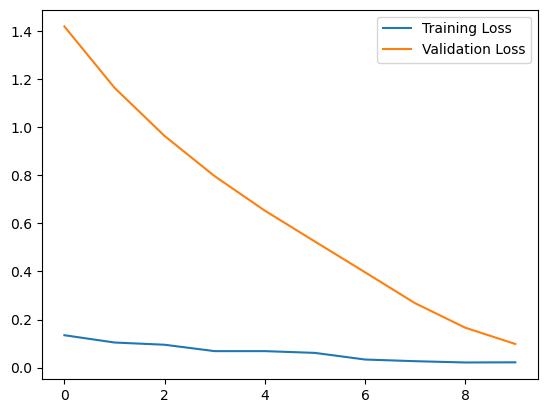

In [6]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [20]:
import pandas as pd
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Encode the text for BERT
def encode_for_bert(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="tf", max_length=500)

# Load dataset
train_df = pd.read_csv("train.csv")  # Ensure your train file is correctly formatted
test_df = pd.read_csv("test.csv")  # Ensure your test file is correctly formatted

# Encode train and test data
train_encodings = encode_for_bert(train_df["extracted_text"].tolist())
test_encodings = encode_for_bert(test_df["extracted_text"].tolist())

# Prepare labels
y_train = train_df["label"].values
test_paper_ids = test_df["filename"].tolist()  # Assuming 'filename' column has the paper IDs

# Define BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Compile the model with `tensorflow.keras.optimizers.Adam`
model.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Train the model
model.fit(
    train_encodings['input_ids'], 
    y_train, 
    epochs=3, 
    batch_size=8, 
    validation_split=0.2
)

# Predict with BERT on test data
predictions = model.predict(test_encodings['input_ids']).logits
predicted_labels = np.argmax(predictions, axis=1)

# Create rationale generation function
def generate_rationale(text):
    return f"The paper's content aligns with the focus areas of the conference due to its strong emphasis on {text[:50]}..."

# Prepare results for `results.csv`
results = []
for paper_id, label, text in zip(test_paper_ids, predicted_labels, test_df["extracted_text"].tolist()):
    if label == 1:  # Publishable
        # Placeholder for conference assignment logic
        conference = "cvpr"  # Modify this logic based on your conference selection framework
        rationale = generate_rationale(text)
    else:
        conference = "na"
        rationale = "na"
    results.append([paper_id, label, conference, rationale])

# Save results to `results.csv`
results_df = pd.DataFrame(results, columns=["Paper ID", "Publishable", "Conference", "Rationale"])
results_df.to_csv("results.csv", index=False)

# Print the first few rows of the results
print(results_df.head())


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x17a116780>